In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sqlalchemy as db

import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score 
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim import Adam

In [28]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))

True
1
0
NVIDIA GeForce GTX 1650


Connection to DLSU Cloud DB (PAL)
- `connection.json` is abstracted for data privacy

In [29]:
conn = pd.read_json('connection.json', typ='series')
host = conn['host']
user = conn['user']
password = conn['password']
port = conn['port']

db_name = input('DB Name: ')
engine = db.create_engine('mysql+pymysql://' + user + ':' + password + '@' + host + ':' + port + '/' + db_name)

DB Name: Historical


Reading the Historical Data

In [30]:
query = "SELECT * FROM PALB777_hour"
hist = pd.read_sql(query, engine)

# EDA & Preprocessing

In [31]:
hist.index = hist['index']
hist.drop('index', axis=1, inplace=True)

In [32]:
hist.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15167 entries, 2022-01-01 00:00:00 to 2023-09-24 22:00:00
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   rp7772  15167 non-null  float64
 1   rp7773  15167 non-null  float64
 2   rp7774  15167 non-null  float64
 3   rp7775  15167 non-null  float64
 4   rp7776  15167 non-null  float64
 5   rp7777  15167 non-null  float64
 6   rp7778  15167 non-null  float64
 7   rp7779  15167 non-null  float64
 8   rp7782  15167 non-null  float64
dtypes: float64(9)
memory usage: 1.2 MB


In [33]:
hist.describe()

,rp7772,rp7773,rp7774,rp7775,rp7776,rp7777,rp7778,rp7779,rp7782
count,15167.000000,15167.000000,15167.000000,15167.000000,15167.000000,15167.000000,15167.000000,15167.000000,15167.000000
mean,9084.342686,5085.247437,569.734959,3459.848711,3675.624093,4694.237881,5817.094252,5701.875285,6154.639672
std,10095.576421,8944.019925,3508.308840,7782.193918,7986.441379,8816.908037,9064.834853,9137.011880,9668.689192
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1762.191111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,17731.146667,11142.077778,0.000000,0.000000,0.000000,761.437778,15609.200000,15453.533333,15790.866667
max,47314.755556,45496.164444,44033.791111,59026.795556,51505.040000,52611.413333,43916.324444,52218.631111,82163.244444


Separate the data

In [34]:
rp72 = hist[['rp7772']].rename({'rp7772':'ff'}, axis=1)
rp73 = hist[['rp7773']].rename({'rp7773':'ff'}, axis=1)
rp74 = hist[['rp7774']].rename({'rp7774':'ff'}, axis=1)
rp75 = hist[['rp7775']].rename({'rp7775':'ff'}, axis=1)
rp76 = hist[['rp7776']].rename({'rp7776':'ff'}, axis=1)
rp77 = hist[['rp7777']].rename({'rp7777':'ff'}, axis=1)
rp78 = hist[['rp7778']].rename({'rp7778':'ff'}, axis=1)
rp79 = hist[['rp7779']].rename({'rp7779':'ff'}, axis=1)
rp782 = hist[['rp7782']].rename({'rp7782':'ff'}, axis=1)

Process the main data (rp7772)

In [35]:
ss = StandardScaler()
ss.fit(rp72) # main data for standardization
time_step = 24*17 # time step for preprocessing
pred_step = 1 # number of predictions

def time_step_prep(data, time_step,pred_step):
    X = []
    y = []
    for i in range(time_step, data.shape[0]-pred_step):
        X.append(list(data.iloc[i-time_step:i, 0].values.reshape(-1)))
        y.append(list(data.iloc[i:i+pred_step, 0].values.reshape(-1)))
    return X, y

In [36]:
n_rp72 = pd.DataFrame(ss.transform(rp72))
X, y = time_step_prep(n_rp72, time_step, pred_step)
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), train_size=0.5, shuffle=False)

Add more data to training set

In [37]:
n_rp = [rp73,rp74,rp75,rp76,rp77,rp78,rp79,rp782]

In [38]:
for each in n_rp:
    n_each = pd.DataFrame(ss.transform(each))
    n_X, n_y = time_step_prep(n_each, time_step, pred_step)
    X_train = np.concatenate([X_train, np.array(n_X)])
    y_train = np.concatenate([y_train, np.array(n_y)])

Convert the data to torch

In [39]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

# Prediction Models

Construct Prediction Models

In [78]:
# LSTM based prediction model
class LSTM_based(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, num_layers):
        super().__init__()
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        self.layer = num_layers
        
        self.lstm = nn.LSTM(self.in_dim, self.hid_dim, self.layer, batch_first=True)
        
        self.fc = nn.Linear(self.hid_dim, self.out_dim)
        
    def forward(self,x):        
        # forward propagate
        out, (h_,c_) = self.lstm(x)
        out = self.fc(out)
        return out
    
# RNN based prediction model
class RNN_based(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, num_layers):
        super().__init__()
        
        # define the dimensions
        self.in_dim = in_dim
        self.hid_dim = in_dim
        self.out_dim = out_dim
        self.layer = num_layers
        
        # define the rnn layer
        self.rnn = nn.RNN(self.in_dim, self.hid_dim, self.layer, nonlinearity='relu', batch_first=True)
        
        # define fully connected layer for output
        self.fc = nn.Linear(self.hid_dim, self.out_dim)
        
    def forward(self,x):
        # forward propagate
        out, _ = self.rnn(x)
        out = self.fc(out)
        return out

# Simple Autoregressive Model
auto_reg = nn.Linear(time_step,pred_step)

In [82]:
input_features = X_train.shape[-1]
hidden_size = 64
num_layers = 4
out_size = 1

model = LSTM_based(input_features, hidden_size, out_size, num_layers)

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
loss_fun = nn.MSELoss()
scheduler = lr_scheduler.StepLR(optimizer, step_size=250, gamma=0.1)

In [83]:
def train_model(model,
               criterion,
               optimizer,
               x_train,
               x_test,
               y_train,
               y_test,
               scheduler=None,
               epochs=500):
    
    train_loss = np.zeros(epochs)
    test_loss = np.zeros(epochs)
    
    for epoch in range(epochs):
        
        # put default model grads to zero
        optimizer.zero_grad()
        
        # predict the output
        pred = model(x_train)
        
        # calculate the loss 
        error = criterion(pred, y_train)
        
        # backpropagate the error
        error.backward()
        
        # update the model parameters
        optimizer.step()
        
        # save the losses 
        train_loss[epoch] = error.item()
        
        # test loss 
        test_pred = model(x_test)
        test_error = criterion(y_test,test_pred)
        test_loss[epoch] = test_error.item()
        
        # scheduler
        if scheduler is not None:
            scheduler.step()
        
        if (epoch+1) % 5 ==0:
            print('Epoch :{}    Train Loss :{}    Test Loss :{}'.format((epoch+1)/epochs, error.item(), test_error.item()))
            
    return train_loss, test_loss

In [ ]:
train_loss, test_loss = train_model(
    model, 
    loss_fun,
    optimizer, 
    X_train, 
    X_test,
    y_train, 
    y_test,
    scheduler,
    500
)

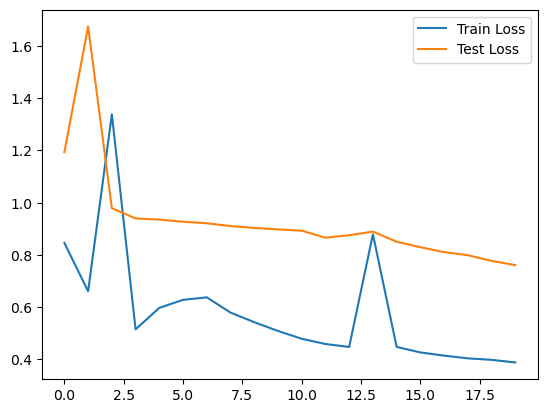

In [47]:
ax = plt.subplot()
ax.plot(train_loss, label='Train Loss')
ax.plot(test_loss, label='Test Loss')
ax.legend()

Single-step prediction

In [48]:
actual = pd.DataFrame(ss.inverse_transform(y_test.detach().numpy().reshape(-1,1))).rename({0:'actual'},axis=1)
pred = pd.DataFrame(ss.inverse_transform(auto_reg(X_test).detach().numpy())).rename({0:'single_pred'},axis=1)

<Axes: >

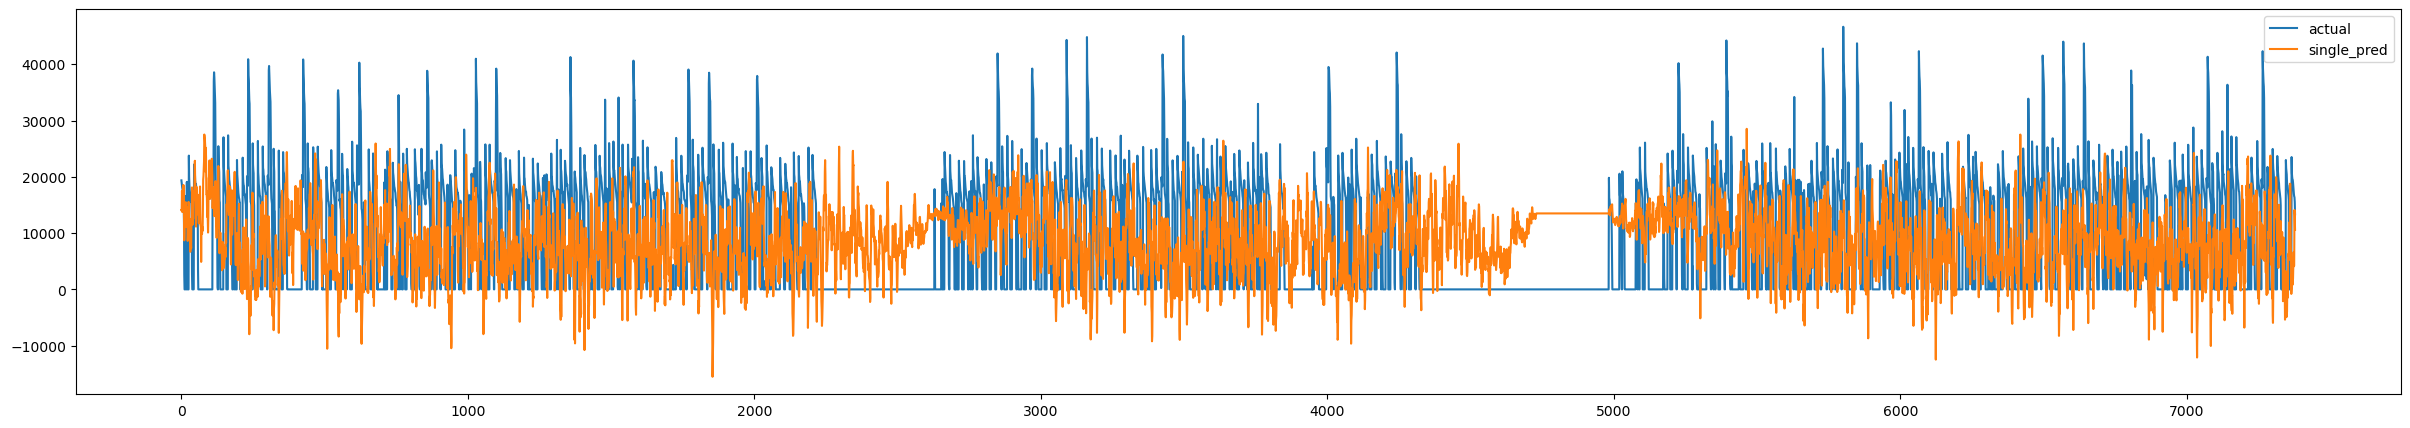

In [49]:
actual_pred = pd.concat([actual, pred], axis=1)
actual_pred.plot(figsize=(30,5))

In [50]:
rmse = float(np.sqrt(sum((actual.values - pred.values)**2)/len(actual)))
r2 = r2_score(actual, pred)

print("RMSE:", rmse)
print("R2:", r2)

RMSE: 12245.3896484375
R2: -0.43146974774045543


Multi-step prediction

In [31]:
multi_pred = []
currX = X_test[0]

while len(multi_pred) != len(X_test):
    tensor_pred = auto_reg(currX)
    currX = torch.cat([currX, tensor_pred])
    currX = currX[-time_step:]
    pred = ss.inverse_transform(tensor_pred.detach().numpy().reshape(-1,1))
    multi_pred.append(float(pred))

In [32]:
pred_step = pd.DataFrame({"multi_pred":multi_pred})
pred_step.index = actual_pred.index

<Axes: >

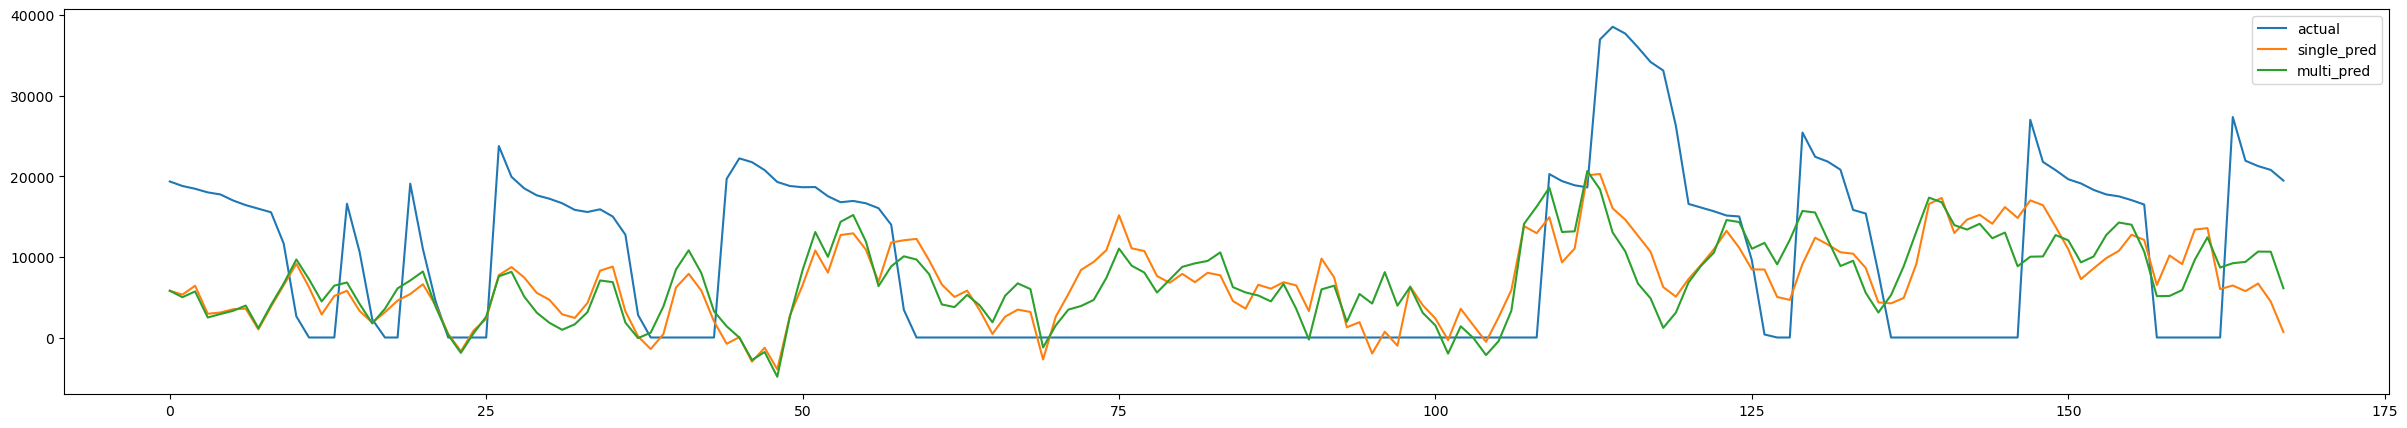

In [33]:
pd.concat([actual_pred, pred_step], axis=1)[:24*7].plot(figsize=(30,5))

In [23]:
pd.concat([actual_pred, pred_step], axis=1)[:24*7].sum().reset_index()

,index,0
0,actual,1.533315e+06
1,single_pred,1.507399e+06
2,multi_pred,1.533722e+06


For multiple step models

<Axes: >

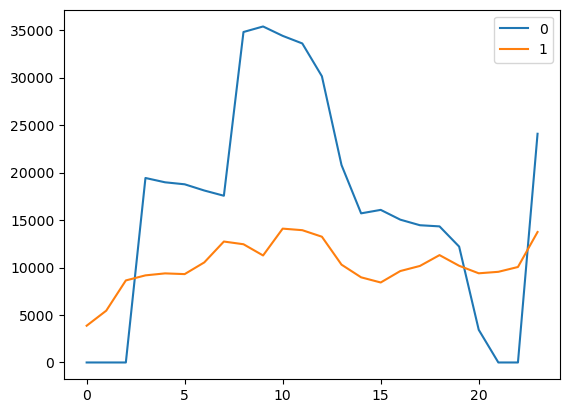

In [161]:
i = 550
actual = ss.inverse_transform(y_test[i].detach().numpy().reshape(-1,1))
pred = ss.inverse_transform(auto_reg(X_test[i]).detach().numpy().reshape(-1,1))
pd.DataFrame(np.concatenate([actual, pred], axis=1)).plot()

# Sampler

In [79]:
class Single_step_PredSampler():
    def __init__(self, time_step, model, data):
        self.time_step = time_step
        self.model = model
        self.data = data
    def predict(self, numhours_to_predict, date_to_pred, plane_to_test):
        orig_date_to_pred = pd.to_datetime(date_to_pred)
        date_to_pred = pd.to_datetime(date_to_pred)
        input_start_date = date_to_pred - pd.Timedelta(hours=self.time_step)
        input_end_date = date_to_pred - pd.Timedelta(hours=1)
        input_df = self.data[plane_to_test][input_start_date:input_end_date]
        input_X = input_df.values.reshape(-1,1)
        ss = StandardScaler()
        s_input_X = ss.fit_transform(input_X)
        ts_input_X = torch.from_numpy(s_input_X.reshape(-1).astype(np.float32))
        mul_ts_input_X = ts_input_X
        pred_list = []
        
        for i in range(numhours_to_predict):
            ts_pred = self.model(ts_input_X)
            mul_ts_pred = self.model(mul_ts_input_X)
            actual = hist[plane_to_test][date_to_pred]
            single_pred = ss.inverse_transform(ts_pred.detach().numpy().reshape(-1,1))
            multi_pred = ss.inverse_transform(mul_ts_pred.detach().numpy().reshape(-1,1))
            date_to_pred += pd.Timedelta(hours=1)
            
            add_actual = torch.from_numpy(ss.transform(np.array(actual).reshape(-1,1)).reshape(-1).astype(np.float32))
            ts_input_X = torch.cat([ts_input_X, add_actual])[1:]
            mul_ts_input_X = torch.cat([mul_ts_input_X, mul_ts_pred])[1:]
            
            pred_list.append([actual, single_pred[0][0], multi_pred[0][0]])
            
        actual_data = hist[plane_to_test][orig_date_to_pred:orig_date_to_pred + pd.Timedelta(hours=numhours_to_predict-1)]
        pred_df = pd.DataFrame(np.array(pred_list))
        pred_df.columns = ['actual', 'single_pred', 'multi_pred']
        pred_df.index = actual_data.index
        return pred_df
    
class Multi_step_PredSampler():
    def __init__(self, time_step, model, data):
        self.time_step = time_step
        self.model = model
        self.data = data
    def predict(self, date_to_pred, plane_to_test):
        orig_date_to_pred = pd.to_datetime(date_to_pred)
        date_to_pred = pd.to_datetime(date_to_pred)
        input_start_date = date_to_pred - pd.Timedelta(hours=self.time_step)
        input_end_date = date_to_pred - pd.Timedelta(hours=1)
        input_df = self.data[plane_to_test][input_start_date:input_end_date]
        input_X = input_df.values.reshape(-1,1)
        ss = StandardScaler()
        s_input_X = ss.fit_transform(input_X)
        ts_input_X = torch.from_numpy(s_input_X.reshape(-1).astype(np.float32))
        pred = self.model(ts_input_X)
        pred_df = pd.DataFrame(ss.inverse_transform(pred.detach().numpy().reshape(-1,1)))
        actual_df = self.data[plane_to_test][orig_date_to_pred:orig_date_to_pred + pd.Timedelta(hours=self.model.out_features-1)]
        pred_df.index = actual_df.index
        actual_pred = pd.concat([actual_df, pred_df], axis=1)
        actual_pred.columns = ['actual', 'multi_pred']
        return actual_pred

In [80]:
multi_pred_sampler = Multi_step_PredSampler(time_step, auto_reg, hist)

<Axes: xlabel='index'>

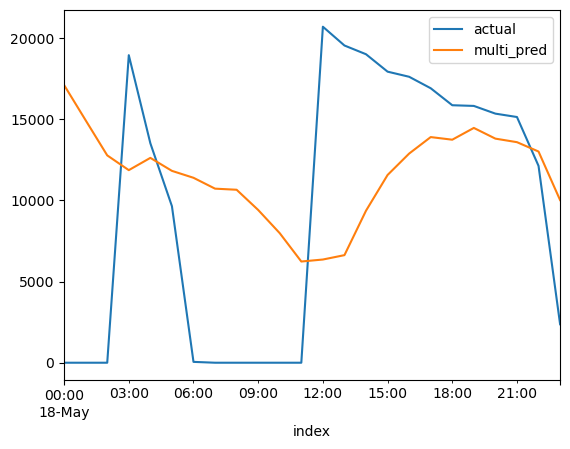

In [88]:
multi_pred_sampler.predict('2022-05-18', 'rp7772').plot()

In [ ]:
pred_sampler = Single_step_PredSampler(time_step, auto_reg, hist)

In [ ]:
multi_agg = []
for each in hist.iloc[time_step:,0].index:
    result = pred_sampler.predict(24*2, each, 'rp7772')
    multi_agg.append(list(result.sum().values))
    print(each)

In [33]:
multi_agg_df = pd.DataFrame(multi_agg)
multi_agg_df.index = hist.iloc[time_step:len(multi_agg_df) + time_step,0].index
multi_agg_df.columns = ['actual', 'single_pred', '24*2_pred']

<Axes: xlabel='index'>

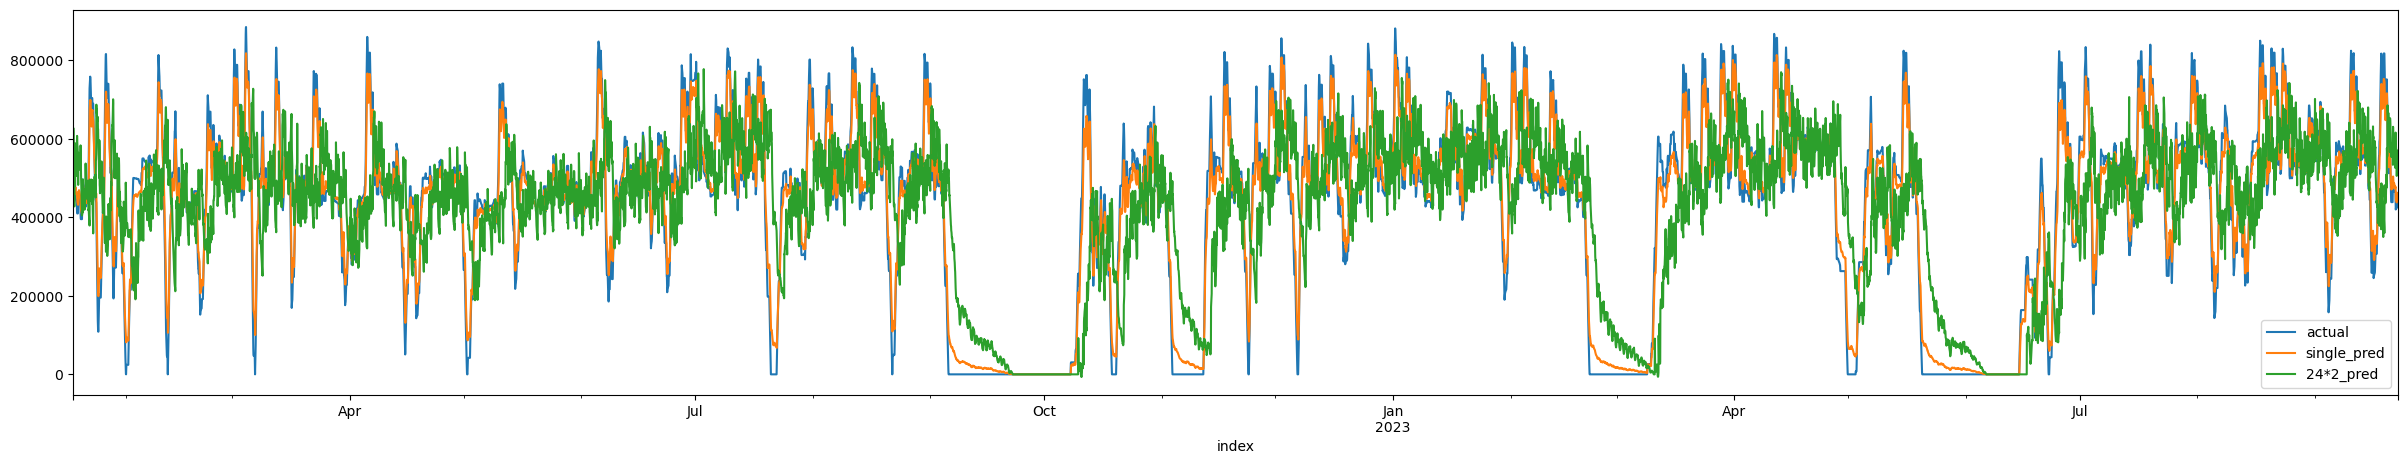

In [34]:
print('lagr2:', r2_score(lag['actual'], lag['lag_pred']))
print('lagrmse:', np.sqrt(sum((lag['actual'] - lag['lag_pred'])**2)/len(lag)))
multi_agg_df.plot(figsize=(30,5))

In [22]:
def simulate_lag(lag, multi_agg_df):
    lag_df = multi_agg_df['24*7_pred'][lag:].reset_index().drop('index', axis=1)
    lag_df = pd.concat([lag_df,pd.DataFrame({'24*7_pred':[np.NaN] * lag})]).reset_index().drop('index', axis=1)
    lag_df = lag_df.rename({'24*7_pred':'lag_pred'}, axis=1)
    lag_df.index = multi_agg_df.index
    return pd.concat([multi_agg_df, lag_df], axis=1)

lagr2: 0.8654399435259836
lagrmse: 243974.59875656164


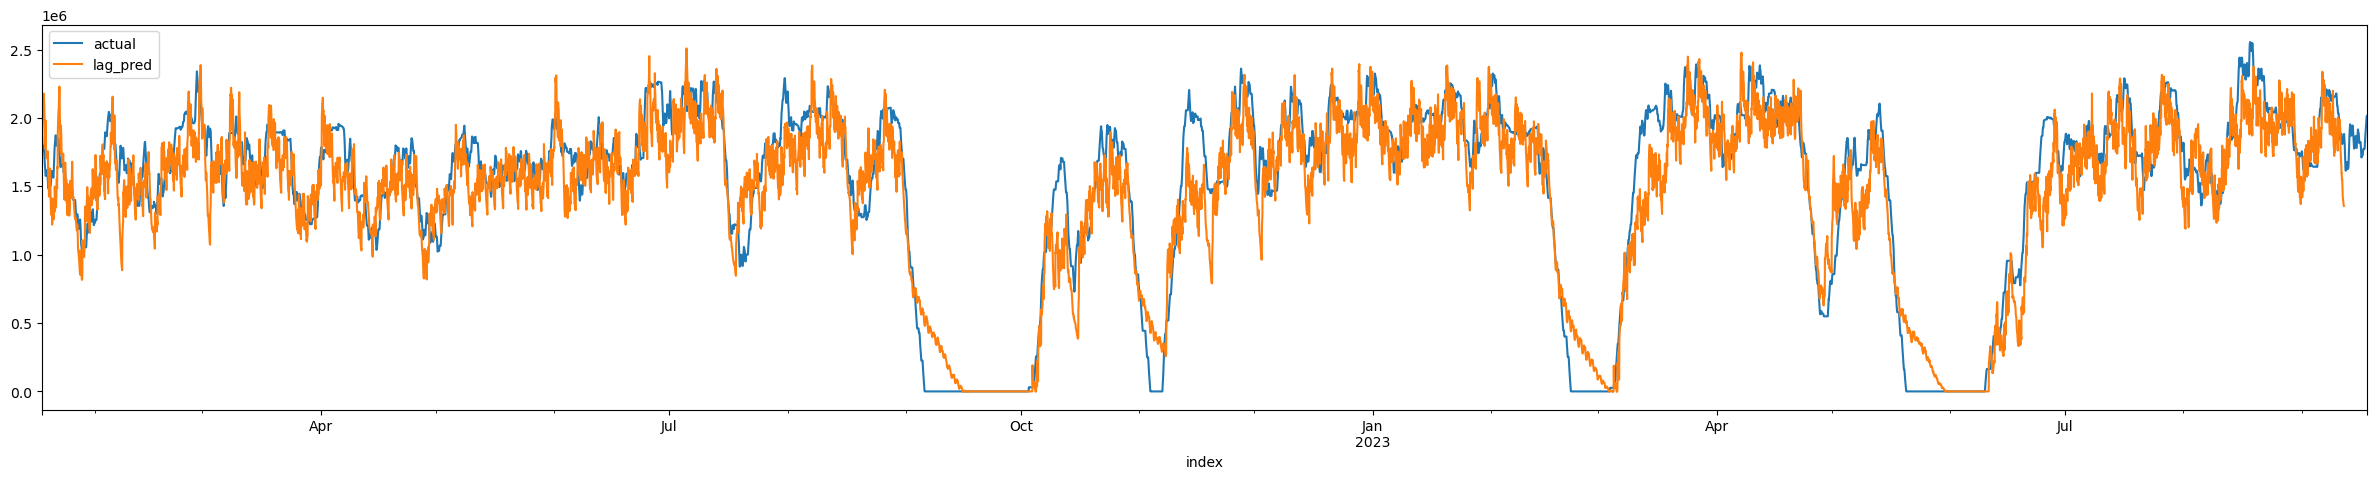

In [23]:
lag_version = simulate_lag(24*6, multi_agg_df)
lag_version[['actual', 'lag_pred']].plot(figsize=(30,5))
lag = lag_version.dropna()[['actual', 'lag_pred']]
print('lagr2:', r2_score(lag['actual'], lag['lag_pred']))
print('lagrmse:', np.sqrt(sum((lag['actual'] - lag['lag_pred'])**2)/len(lag)))

# Save/Load Model

In [15]:
directory = input('Directory to save the model: ')
filename = input('Model Name: ')
torch.save(auto_reg, directory + filename + '.pt')

Directory to save the model: C:\Users\Kyle Carlo C. Lasala\Desktop\PAL\repo\Predicting-Fuel-Consumption\
Model Name: AutoRegressive-Multistep


NameError: name 'auto_reg' is not defined

In [16]:
directory = input('Directory to save the model: ')
filename = input('Model Name: ')
load_mod = torch.load(directory + filename + '.pt')
load_mod.eval()

Directory to save the model: C:\Users\Kyle Carlo C. Lasala\Desktop\PAL\repo\Predicting-Fuel-Consumption\
Model Name: AutoRegressive-Multistep


Linear(in_features=408, out_features=24, bias=True)